## Implementing a Regression Tree from Scratch


In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

## Dataset 

First things first! Let us load Boston dataset and shuffle. We then split the data to training and test folds. We use pandas to access the features easily

In [2]:
def prepare_dataset():
    boston = load_boston()
    X_y = np.column_stack([boston['data'], boston['target']])
    np.random.seed(1)
    np.random.shuffle(X_y)
    X, y = X_y[:,:-1], X_y[:,-1]
    X_train, y_train, X_test, y_test = X[:400], y[:400], X[400:], y[400:]
    X_train = pd.DataFrame(X_train, columns=boston['feature_names'])
    X_test = pd.DataFrame(X_test, columns=boston['feature_names'])
    y_train = pd.Series(y_train, name='House Price')
    y_test = pd.Series(y_test, name='House Price')
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = prepare_dataset()
X_train.head()

d:\SOFTWARES\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.04932,33.0,2.18,0.0,0.472,6.849,70.3,3.1827,7.0,222.0,18.4,396.90,7.53
1,0.02543,55.0,3.78,0.0,0.484,6.696,56.4,5.7321,5.0,370.0,17.6,396.90,7.18
2,0.22927,0.0,6.91,0.0,0.448,6.030,85.5,5.6894,3.0,233.0,17.9,392.74,18.80
3,0.05789,12.5,6.07,0.0,0.409,5.878,21.4,6.4980,4.0,345.0,18.9,396.21,8.10
4,3.67822,0.0,18.10,0.0,0.770,5.362,96.2,2.1036,24.0,666.0,20.2,380.79,10.19


## Regression Tree

### Splitting Criteria: RSS

Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-\hat{y_{L}}\right)^{2}+\sum_{\text {right }}\left(y_{i}-\hat{y_{R}}\right)^{2}$$

where $\hat{y_L} and \hat{y_r}$ are mean y-value of left and right nodes.

In [3]:
def rss(y_left, y_right):
    def squared_residual_sum(y):
        return np.sum((y - np.mean(y)) ** 2)
    
    return squared_residual_sum(y_left) + squared_residual_sum(y_right) 

We now plot RSS of two features with respect to each possible threshold. We choose continous features with the strongest correlation (LSTAT) and weakest correlation (DIS).

We observe that LSTAT can create much better splits than DIS, given its much lower RSS. We also observe parabola-like shapes for both features, indicating that both features have meaningful split points.

In [4]:
def compute_rss_by_threshold(feature):
    features_rss = []
    thresholds = X_train[feature].unique().tolist()
    thresholds.sort()
    thresholds = thresholds[1:]
    for t in thresholds:
        y_left_ix = X_train[feature] < t
        y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
        features_rss.append(rss(y_left, y_right))
    return thresholds, features_rss

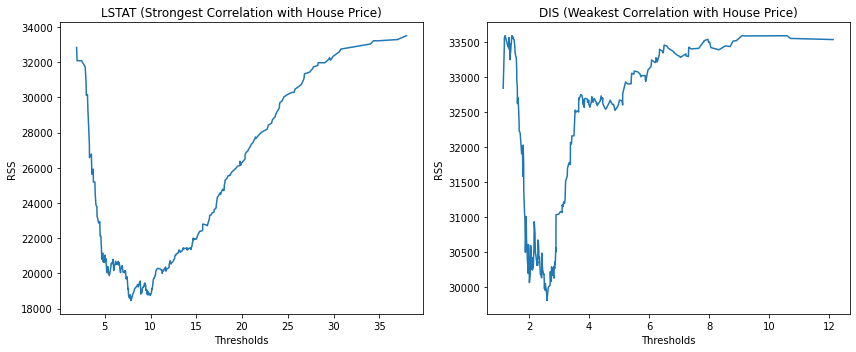

In [5]:
lstat_thresholds, lstat_rss = compute_rss_by_threshold('LSTAT')
dis_thresholds, dis_rss = compute_rss_by_threshold('DIS')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.xlabel('Thresholds')
plt.ylabel('RSS')
plt.title('LSTAT (Strongest Correlation with House Price)')
plt.plot(lstat_thresholds, lstat_rss)

plt.subplot(1, 2, 2)
plt.xlabel('Thresholds')
plt.ylabel('RSS')
plt.title('DIS (Weakest Correlation with House Price)')
plt.plot(dis_thresholds, dis_rss)

plt.tight_layout()
plt.show()

### Splitting

We now implement the recursive splitting procedure as a function. We greedily find the best rules and split the data accordingly. We store the rules in a dictionary. Last, we use a helper function to find the best rule during each split.

We call the function to create a tree with depth 3 and visualize the result.

In [6]:
def find_best_rule(X_train, y_train):
    best_feature, best_threshold, min_rss = None, None, np.inf
    for feature in X_train.columns:
        thresholds = X_train[feature].unique().tolist()
        thresholds.sort()
        thresholds = thresholds[1:]
        for t in thresholds:
            y_left_ix = X_train[feature] < t
            y_left, y_right = y_train[y_left_ix], y_train[~y_left_ix]
            t_rss = rss(y_left, y_right)
            if t_rss < min_rss:
                min_rss = t_rss
                best_threshold = t
                best_feature = feature
    
    return {'feature': best_feature, 'threshold': best_threshold}

In [7]:
def split(X_train, y_train, depth, max_depth):
    if depth == max_depth or len(X_train) < 2:
        return {'prediction': np.mean(y_train)}
    
    rule = find_best_rule(X_train, y_train)
    left_ix = X_train[rule['feature']] < rule['threshold']
    rule['left'] = split(X_train[left_ix], y_train[left_ix], depth + 1, max_depth)
    rule['right'] = split(X_train[~left_ix], y_train[~left_ix], depth + 1, max_depth)
    return rule

rules = split(X_train, y_train, 0, 3)

Now let us finish the regression tree by implementing the prediction function. We apply the rules in the rule tree until we arrive at a leaf

In [8]:
def predict(sample, rules):
    prediction = None
    while prediction is None:
        feature, threshold = rules['feature'], rules['threshold']
        if sample[feature] < threshold:
            rules = rules['left']
        else:
            rules = rules['right']
        prediction = rules.get('prediction', None)
    return prediction

## Evaluation

We evaluate the regression tree by creating trees at different depths and measuring the $R^2$ on the test set

In [9]:
def evaluate(X, y):
    preds = X.apply(predict, axis='columns', rules=rules.copy())
    return r2_score(preds, y)

In [10]:
X_train, y_train, X_test, y_test = prepare_dataset()
for max_depth in range(3, 11):
    rules = split(X_train, y_train, 0, max_depth)
    train_r2 = evaluate(X_train, y_train)
    test_r2 = evaluate(X_test, y_test)
    print('Max Depth', max_depth, 'Training R2:', train_r2, 'Test R2:',test_r2)

d:\SOFTWARES\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Max Depth 3 Training R2: 0.7708091374308115 Test R2: 0.7196592096391115
Max Depth 4 Training R2: 0.8627064343049947 Test R2: 0.8692394590216349
Max Depth 5 Training R2: 0.9103985407014502 Test R2: 0.8483933516884553
Max Depth 6 Training R2: 0.9386306329825314 Test R2: 0.8610730600853665
Max Depth 7 Training R2: 0.9567008693137388 Test R2: 0.8766769478534068
Max Depth 8 Training R2: 0.9711559479122112 Test R2: 0.8657586402255723
Max Depth 9 Training R2: 0.9795840439772386 Test R2: 0.8653608796726965
Max Depth 10 Training R2: 0.9852945061378401 Test R2: 0.864643126910721
